## LightGBM

In [4]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import sys
sys.path.append(os.getcwd() + "/..")
from utils import plot_correlogram
import feature_engineering as fe
import warnings
from scipy import stats
from sklearn.model_selection import train_test_split
from utils import combine_data
from sklearn.pipeline import make_pipeline
warnings.filterwarnings('ignore')
random_state=123456789
np.random.seed(123456789)
from utils import plot_correlogram, nmae, nmae_scorer, mape_scorer, mean_squared_error_scorer, corr_metric_scorer
from typing import Dict
from sklearn.utils import shuffle
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import learning_curve
#models
import statsmodels.api as sm
import lightgbm as lgb
from hyperopt import hp, tpe, Trials
from hyperopt.fmin import fmin
from hyperopt.pyll import scope
import hyperopt
import tqdm

#vis
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('bmh')
from plotly import express as px
from plotly import graph_objects as go
from plotly import offline as pyo

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read Data

In [5]:
meta, data =pd.read_pickle("../data/forecast_data_2020.p")

In [6]:
homes_indexes = data.columns.get_level_values(0).unique()

In [7]:
homes_indexes

Index(['854', '123', '852', '222', '484', '404', '992', '319', '583', '801',
       '987', '299', '640', '744', '241', '200', '441', '192', '621', '313',
       '464', '424', '993', '598', '514', '268', '745', '927', '945', '352',
       '980', '644', '683', '244', '677', '351', '118', '595', '255', '554',
       '318', '743', '947', '480', '219', '780', '909', '977', '272', '246',
       '521', '842', '267', '396', '290', '601', '901', '260', '618', '629',
       '238', '231', '875', '889', '340', '906', '604', '525', '460', '130',
       '363', '250', '666', '438', '986', '462', '188', '763', '923', '925',
       '822', '131', '456', '624', '827', '474', '859', '912', '194', '706',
       '522', '999', '113', '247', '657', '890', '412', '261', '957', '600'],
      dtype='object')

## Feature Engineering

### Target
Since at time step T we need to predict the value given at step T+1, but at step T
we only know values from step T-1 (make prediction on Wednesday about Constumption on Thursday, given known values of consumption only at Teusday, thus we need to shift by 2 * 24h = 48h

In [8]:
target = make_pipeline(fe.FeatureSelector('consumption'), fe.CalcShift(-48),fe.CastType(float), fe.ApplyLogTransformation())

### Current consumption
consumption at step T-1 won't require any shift

In [9]:
prev_consumption = make_pipeline(fe.FeatureSelector('consumption'), fe.CastType(float),fe.ApplyLogTransformation())
# prev_consumption_ago = fe.make_union(*(make_pipeline(fe.FeatureSelector('consumption'), fe.CalcShift(i*24), fe.CastType(float)) for i in range(1,2)))
rolling_window = fe.make_union(*(make_pipeline(fe.FeatureSelector('consumption'),fe.CastType(float),fe.ApplyLogTransformation(), fe.ApplyRollingWindowMean(i*24)) for i in range(1,4)))

### Weather

Note all weather prediction for T+1 is given at step T, thus we need to shift for 24h

In [10]:
temperature = make_pipeline(fe.FeatureSelector('temperature'), fe.CalcShift(-48), fe.CastType(float))
humidity = make_pipeline(fe.FeatureSelector('humidity'), fe.CalcShift(-48), fe.CastType(float))
cloudiness = make_pipeline(fe.FeatureSelector('cloudiness'), fe.CalcShift(-48), fe.CastType(float))

### Extract Day Time

In [11]:
day_time =  make_pipeline(fe.FeatureSelector('time'), fe.ExtractDayTime(), fe.OneHot(drop_first=False))

### Extract season name from date

In [12]:
season = make_pipeline(fe.FeatureSelector('time'), fe.ExtractSeason(), fe.OneHot(drop_first=False))

### Combine Features

In [13]:
feature_union = fe.make_union(prev_consumption,
                              temperature,
                              humidity,
                              cloudiness,
                              day_time,
                              season,
                              target
                              )
feature_union

PandasFeatureUnion(transformer_list=[('pipeline-1',
                                      Pipeline(steps=[('featureselector',
                                                       FeatureSelector(feature_name='consumption')),
                                                      ('casttype', CastType()),
                                                      ('applylogtransformation',
                                                       ApplyLogTransformation())])),
                                     ('pipeline-2',
                                      Pipeline(steps=[('featureselector',
                                                       FeatureSelector(feature_name='temperature')),
                                                      ('calcshift',
                                                       CalcShift(shift_val=-48)),
                                                      ('castt...
                                     ('pipeline-6',
                                      Pipeline(steps=[('featureselector',
                                                       FeatureSelector(feature_name='time')),
                                                      ('extractseason',
                                                       ExtractSeason()),
                                                      ('onehot', OneHot())])),
                                     ('pipeline-7',
                                      Pipeline(steps=[('featureselector',
                                                       FeatureSelector(feature_name='consumption')),
                                                      ('calcshift',
                                                       CalcShift(shift_val=-48)),
                                                      ('casttype', CastType()),
                                                      ('applylogtransformation',
                                                       ApplyLogTransformation())]))])

## Transform

In [14]:
def create_samples(home_indexes_subsample):
    df_dict = {}
    for home_i in list(home_indexes_subsample):
        if home_i in ["268"]: # outlier
            continue
        temp_df = data[home_i]
        temp_df["time"] = temp_df.index
        temp_df = feature_union.fit_transform(temp_df)
        # prev_cons_agp = prev_consumption_ago.fit_transform(data[home_i])
        # temp_df = temp_df.merge(prev_cons_agp, left_index=True, right_index=True, how="inner")
        rolling = rolling_window.fit_transform(data[home_i])
        temp_df = temp_df.merge(rolling, left_index=True, right_index=True, how="inner")
        temp_df = temp_df.reset_index().drop_duplicates(subset='time', keep="last").set_index("time")
        temp_df["ev"] = meta[home_i]["has_electric_vehicle"] +0
        temp_df["home_num"] = home_i

        df_dict[home_i] = temp_df
    return df_dict

#Train data
train_homes_indexes_subsample = np.random.choice(homes_indexes,2,replace =False)
df_dict_train = create_samples(train_homes_indexes_subsample)
df_train = combine_data(df_dict_train)

#Test data
test_homes_indexes_subsample = [i for i in homes_indexes if i not in train_homes_indexes_subsample]
df_dict_test = create_samples(test_homes_indexes_subsample)
df_test = combine_data(create_samples(df_dict_test))

In [15]:
df_train.columns

Index(['consumption', 'forward_temperature_48', 'forward_humidity_48',
       'forward_cloudiness_48', 'day_time_Day Time',
       'day_time_Day Time Peak Hour', 'day_time_Evening', 'day_time_Morning',
       'day_time_Night', 'season_Autumn', 'season_Spring', 'season_Summer',
       'season_Winter', 'forward_consumption_48',
       'rolling_mean_24_consumption', 'rolling_mean_48_consumption',
       'rolling_mean_72_consumption', 'ev', 'home_num'],
      dtype='object')

In [16]:
FEATURES = ['consumption', 'forward_temperature_48', 'forward_humidity_48',
       'forward_cloudiness_48', 'day_time_Day Time',
       'day_time_Day Time Peak Hour', 'day_time_Evening', 'day_time_Morning',
       'day_time_Night', 'season_Autumn', 'season_Spring', 'season_Summer',
       'season_Winter', 'ev','rolling_mean_24_consumption', 'rolling_mean_48_consumption',
       'rolling_mean_72_consumption' ]
TARGET = 'forward_consumption_48'

In [17]:
# Since we transformed the problem from Time-Series to Tabular, we allowed to shuffle it
df_train = shuffle(df_train)
df_test = shuffle(df_test)
# df_train = df_train.reset_index().sort_values(by=["time","home_num"]).set_index("time")
# df_test = df_test.reset_index().sort_values(by=["time","home_num"]).set_index("time")

X_train, y_train = df_train[FEATURES], df_train[TARGET]
X_test, y_test = df_test[FEATURES], df_test[TARGET]

In [18]:
print(X_train.shape)

(17332, 17)


In [19]:
print(X_test.shape)

(840602, 17)


## Check Params Linear Signifance

In [23]:
mod = sm.OLS(y_train[:1000],X_train.iloc[:1000],prepend=True)
res = mod.fit()
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     forward_consumption_48   R-squared:                       0.462
Model:                                OLS   Adj. R-squared:                  0.454
Method:                     Least Squares   F-statistic:                     56.37
Date:                    Wed, 05 Oct 2022   Prob (F-statistic):          3.53e-121
Time:                            21:48:47   Log-Likelihood:                -548.88
No. Observations:                    1000   AIC:                             1130.
Df Residuals:                         984   BIC:                             1208.
Df Model:                              15                                         
Covariance Type:                nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

## Model LIGHTGBM

In [26]:
def cross_validation_time_series(estimator: callable,
                                 X: pd.DataFrame,
                                 y: pd.DataFrame,
                                 cv: int,
                                 params: Dict,
                                 scoring: callable):
    global train_index, test_index
    tscv = TimeSeriesSplit(n_splits=cv)
    val_scores = []
    for train_index, test_index in tscv.split(X):
        train_index_max = train_index[-1]
        test_index_max = test_index[-1]
        X_train, X_val = X.iloc[:train_index_max], X.iloc[train_index_max: test_index_max]
        y_train, y_val = y.iloc[:train_index_max], y.iloc[train_index_max: test_index_max]
        model = estimator(**params)
        model.fit(X_train, y_train)
        val_scores.append(scoring(model, X_val, y_val))
    return np.mean(val_scores)


def cross_validation(estimator: callable,
                     X: pd.DataFrame,
                     y: pd.DataFrame,
                     cv: int,
                     params: Dict,
                     scoring: callable):
    regressor = estimator(**params)
    scores = cross_val_score(estimator=regressor,
                             X=X,
                             y=y,
                             cv=cv,
                             scoring=scoring)
    return scores

# Setup objective function
def objective(params):
    scores = cross_validation(**params["cv_config"],
                              params=params["space"])  
    return np.mean(scores)

In [84]:
pd.concat([X_train,y_train],axis=1)[["forward_consumption_48"]]

,forward_consumption_48
time,
2020-01-03 23:00:00,1.701105
2020-01-04 00:00:00,1.591274
2020-01-04 01:00:00,1.693779
2020-01-04 02:00:00,1.631199
2020-01-04 03:00:00,1.756132
...,...
2020-12-29 20:00:00,1.846563
2020-12-29 21:00:00,1.639191
2020-12-29 22:00:00,1.875641


In [90]:
SCORING = nmae_scorer
CV_CONFIG = {"estimator": lgb.LGBMRegressor,
             "X": X_train,
             "y": y_train,
             "cv": 10,
             "scoring": SCORING
            }

# Informative Priors
# {'colsample_bytree': 0.7875512057359588,
#  'learning_rate': 0.17401909074730884,
#  'max_depth': 2.949967343538605,
#  'num_iterations': 129.9632860551049,
#  'num_leaves': 7.409115274158607,
#  'reg_lambda': 76.35321348391048,
#  'subsample': 0.9299723490982507}
space = {
    'learning_rate':    hp.uniform('learning_rate', 0.01, 1),
    'num_leaves':       scope.int(hp.uniform('num_leaves', 2, 10)),
    'max_depth':        scope.int(hp.uniform('max_depth', 1, 3)),
    'subsample':        hp.uniform('subsample', 0.6, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1), #feature_fraction
    'num_iterations':   scope.int(hp.uniform('num_iterations',10, 300)),
    # 'reg_alpha':        hp.uniform("reg_alpha",0, 100), #L1
    # 'reg_lambda':        hp.uniform("reg_lambda",0, 10), #L2
    'seed': random_state
        }

params = {"cv_config":CV_CONFIG,
          "space": space}


    
def customStopCondition(x, *kwargs):
    return x.best_trial["result"]["loss"] < 0.00001, kwargs
    
trials = Trials()
best = fmin(fn=objective,
            space=params,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials,
            rstate=np.random.default_rng(random_state),
            early_stop_fn=customStopCondition)
best

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.16trial/s, best loss: 0.005407556397025542]


{'colsample_bytree': 0.796142303119546,
 'learning_rate': 0.8658397124372436,
 'max_depth': 2.0018072862998206,
 'num_iterations': 224.34755755179458,
 'num_leaves': 6.682772035882616,
 'subsample': 0.8339864507209195}

#### Re-Train the Model with best Params

In [91]:
int_col_names = ["max_depth", "num_iterations","num_leaves"]
def map_to_int(params):
    params_mapped = {}
    for key, val in params.items():
        if key in int_col_names:
            params_mapped[key] = round(val)
        else:
            params_mapped[key] = val
    return params_mapped
        
best_params = map_to_int(best)

model = lgb.LGBMRegressor(**best_params)
model.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.796142303119546,
              learning_rate=0.8658397124372436, max_depth=2, num_iterations=224,
              num_leaves=7, subsample=0.8339864507209195)

In [29]:
def unpack(x):
    if x:
        return x[0]
    return np.nan

trials_df = pd.DataFrame([pd.Series(t["misc"]["vals"]).apply(unpack) for t in trials])
trials_df["loss"] = [t["result"]["loss"] for t in trials]
trials_df["trial_number"] = trials_df.index

int_col_names = ["max_depth", "num_iterations","num_leaves"]
for col_name in int_col_names:
    trials_df[col_name] = trials_df[col_name].apply(lambda x: round(x))

In [30]:
trials_df.head(5)

,colsample_bytree,learning_rate,max_depth,num_iterations,num_leaves,subsample,loss,trial_number
0,0.902721,0.953819,3,96,3,0.725267,0.228158,0
1,0.796142,0.865840,2,77,7,0.833986,0.225952,1
2,0.766086,0.259869,2,57,7,0.810593,0.238922,2
3,0.782284,0.886238,1,25,6,0.681912,0.240890,3
4,0.903161,0.100893,3,83,8,0.722977,0.232261,4


#### Trials vs Objective Func

In [ ]:
px.scatter(trials_df, x="trial_number", y="loss")

#### Contour plot
Feature vs Objective Func

Num Leaves vs Num Iteration

In [ ]:
fig = go.Figure(
    data=go.Contour(
        z=trials_df["loss"],
        x=trials_df["num_iterations"],
        y=trials_df["num_leaves"],
        contours=dict(
            showlabels=True,  # show labels on contours
            labelfont=dict(size=12, color="white",),  # label font properties
        ),
        colorbar=dict(title="loss", titleside="right",),
        hovertemplate="loss: %{z}<br>num_iterations: %{x}<br>num_leaves: %{y}<extra></extra>",
    )
)

fig.update_layout(
    xaxis_title="num_iterations",
    yaxis_title="num_leaves",
    title={
        "text": "num_iterations vs. num_leaves",
        "xanchor": "center",
        "yanchor": "top",
        "x": 0.5,
    },
    margin=dict(l=10, r=10, t=10, b=10)
)

learning_rate vs num_iterations

In [ ]:
fig = go.Figure(
    data=go.Contour(
        z=trials_df["loss"],
        x=trials_df["num_iterations"],
        y=trials_df["learning_rate"],
        contours=dict(
            showlabels=True,  # show labels on contours
            labelfont=dict(size=12, color="white",),  # label font properties
        ),
        colorbar=dict(title="loss", titleside="right",),
        hovertemplate="loss: %{z}<br>num_iterations: %{x}<br>learning_rate: %{y}<extra></extra>",
    )
)

fig.update_layout(
    xaxis_title="num_iterations",
    yaxis_title="learning_rate",
    title={
        "text": "num_iterations vs. learning_rate",
        "xanchor": "center",
        "yanchor": "top",
        "x": 0.5,
    },
    margin=dict(l=10, r=10, t=10, b=10)
)

In [64]:
train_sizes, train_scores, test_scores =learning_curve(model,
                                                       X_train,
                                                       y_train,
                                                       scoring=SCORING,
                                                       train_sizes=np.array([i/10 for i in range(1,10)]),
                                                       cv=10)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
# Plot learning curve
plt.grid()
plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
plt.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
plt.legend(loc="best")


KeyboardInterrupt



Text(0.5, 1.0, 'Top 40 feature imporance')

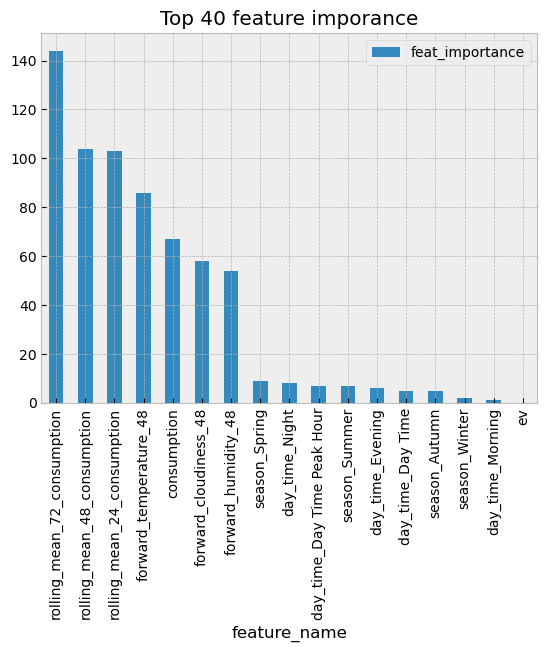

In [87]:
top = 40
df_feat = (
    pd.DataFrame({"feat_importance": model.feature_importances_,
                  "feature_name": X_train.columns})
    .sort_values(by="feat_importance", ascending=False)
          )
df_feat.head(top).plot.bar(x="feature_name", y ="feat_importance")
plt.title(f"Top {top} feature imporance")

## Hyper Parameter Significance

In [65]:
ols = sm.OLS(endog=trials_df['loss'], exog=trials_df.drop(['loss','trial_number'], axis=1)).fit()
print(ols.summary())

                                 OLS Regression Results                                
Dep. Variable:                   loss   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                              823.4
Date:                Wed, 05 Oct 2022   Prob (F-statistic):                    3.92e-06
Time:                        21:53:33   Log-Likelihood:                          35.810
No. Observations:                  10   AIC:                                     -59.62
Df Residuals:                       4   BIC:                                     -57.80
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

## Model Interperation Partial Depedency
Note: Correlation and mutual depedency in between features are ignored

In [97]:
num_feat = 4
fig, ax = plt.subplots(num_feat,1, figsize=(12, 10))
for i in range(num_feat):
    feat = df_feat["feature_name"][i]
    PartialDependenceDisplay.from_estimator(model, X_train, [feat], kind='both', ax=ax[i],subsample=500)

Error in callback <function flush_figures at 0x7fa81a4b8790> (for post_execute):



KeyboardInterrupt



## Model Prediction on Individual House Train

In [33]:
df_dict_train.keys()

dict_keys(['246', '859'])

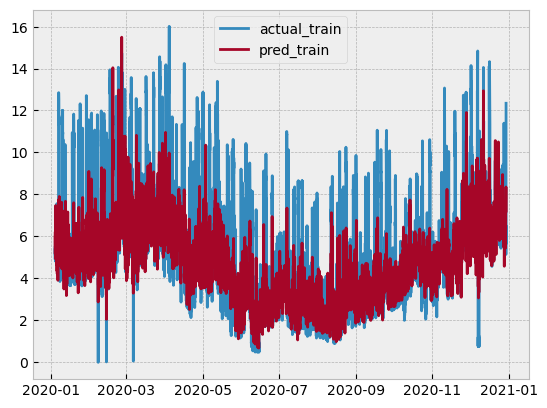

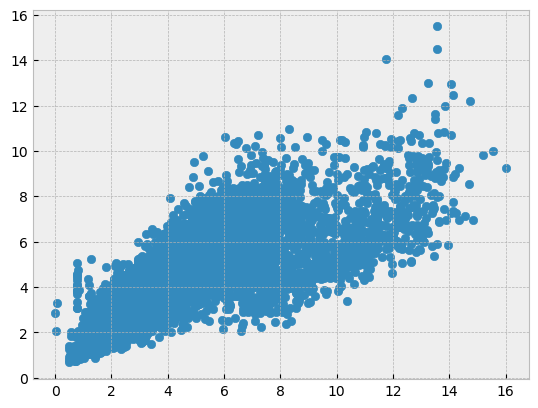

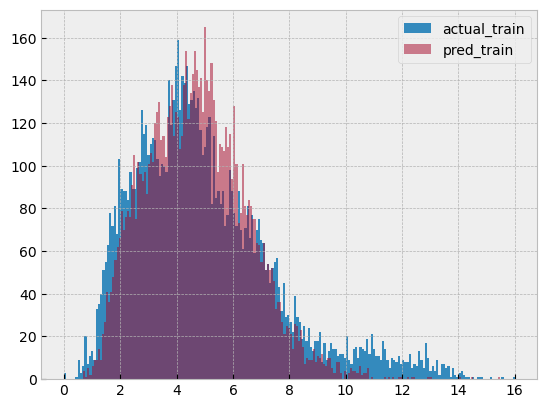

In [88]:
home_num = '859'
X_train, y_train = df_dict_train[home_num][FEATURES], df_dict_train[home_num][TARGET]
pred = model.predict(X_train)
pred_home_train_single = pd.DataFrame({
                            "actual": np.exp(y_train)-0.01,
                            "pred": np.exp(pred)-0.01,
                            "home_num" : home_num})
plt.plot(pred_home_train_single["actual"], label="actual_train")
plt.plot(pred_home_train_single["pred"], label="pred_train")
plt.legend()
plt.show()

plt.scatter(pred_home_train_single["actual"].values,pred_home_train_single["pred"].values) 
plt.show()

plt.hist(pred_home_train_single["actual"], label="actual_train", bins =200)
plt.hist(pred_home_train_single["pred"], label="pred_train",alpha =0.5, bins =200)
plt.legend()
plt.show()

In [80]:
nmae(pred_home_train_single["pred"],pred_home_train_single["actual"])

0.23131565132672163

## Model Prediction on Individual House Test

In [72]:
df_dict_test.keys()

dict_keys(['854', '123', '852', '222', '484', '404', '992', '319', '583', '801', '987', '299', '640', '744', '241', '200', '441', '192', '621', '313', '464', '424', '993', '598', '514', '745', '927', '945', '352', '980', '644', '683', '244', '677', '351', '118', '595', '255', '554', '318', '743', '947', '480', '219', '780', '909', '977', '272', '521', '842', '267', '396', '290', '601', '901', '260', '618', '629', '238', '231', '875', '889', '340', '906', '604', '525', '460', '130', '363', '250', '666', '438', '986', '462', '188', '763', '923', '925', '822', '131', '456', '624', '827', '474', '912', '194', '706', '522', '999', '113', '247', '657', '890', '412', '261', '957', '600'])

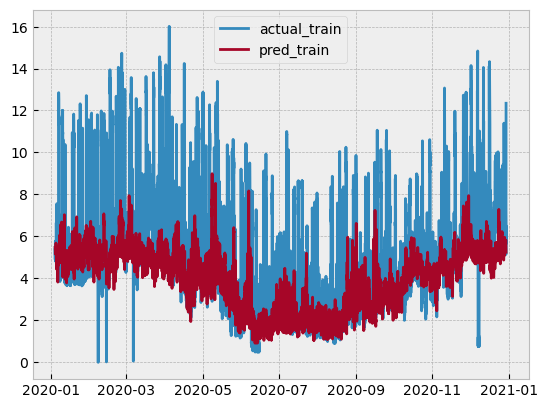

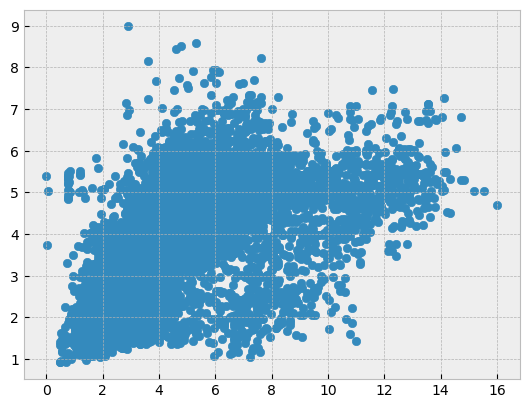

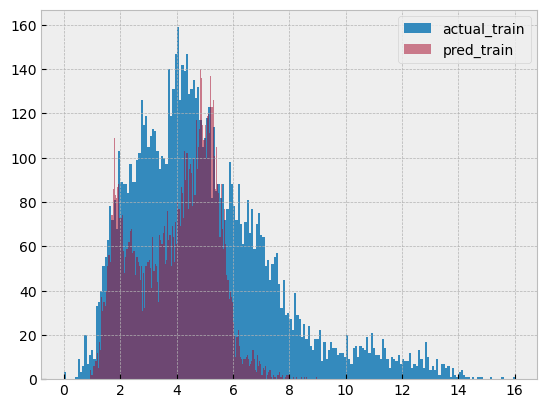

In [81]:
home_num = '319'
X_test, y_test = df_dict_test[home_num][FEATURES], df_dict_test[home_num][TARGET]
pred = model.predict(X_test)
pred_home_test_single = pd.DataFrame({
                            "actual": np.exp(y_train)-0.01,
                            "pred": np.exp(pred)-0.01,
                            "home_num" : home_num})
plt.plot(pred_home_test_single["actual"], label="actual_train")
plt.plot(pred_home_test_single["pred"], label="pred_train")
plt.legend()
plt.show()

plt.scatter(pred_home_test_single["actual"].values,pred_home_test_single["pred"].values) 
plt.show()


plt.hist(pred_home_test_single["actual"], label="actual_train", bins = 200)
plt.hist(pred_home_test_single["pred"], label="pred_train",alpha =0.5, bins = 200)
plt.legend()
plt.show()

In [42]:
nmae(pred_home_test_single["pred"],pred_home_test_single["actual"])

0.3927477366160304

# Porfolio prediction on Train Data Set

In [40]:
pred_home_train = {}
for home_num in df_dict_train.keys():
    X_train, y_train = df_dict_train[home_num][FEATURES], df_dict_train[home_num][TARGET]
    pred = model.predict(X_train)
    pred_home_train[home_num] = pd.DataFrame({
                                 "actual": np.exp(y_train)-0.01,
                                 "pred": np.exp(pred)-0.01,
                                 "home_num" : home_num})
    

In [41]:
portfolio_actual_train = pd.pivot(combine_data(pred_home_train).reset_index(),
                         columns= "home_num",
                         values="actual",
                         index="time").sum(axis=1)

portfolio_pred_train = pd.pivot(combine_data(pred_home_train).reset_index(),
                         columns= "home_num",
                         values="pred",
                         index="time").sum(axis=1)

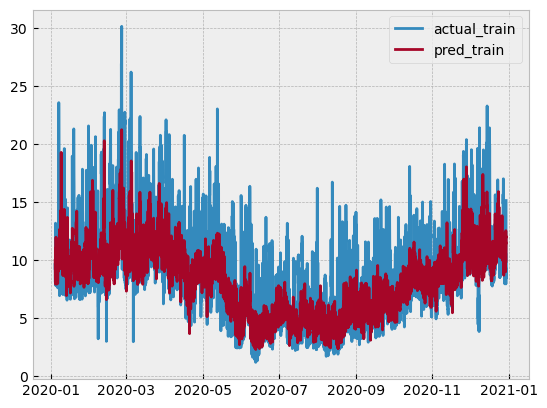

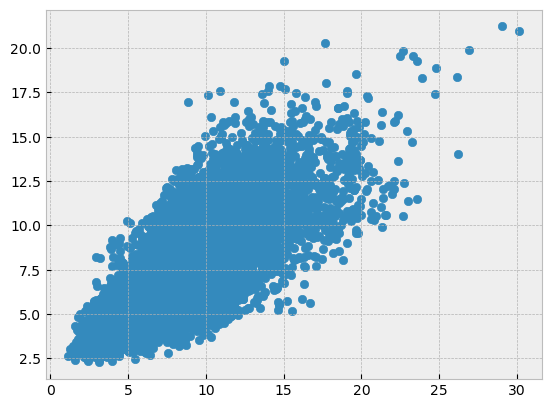

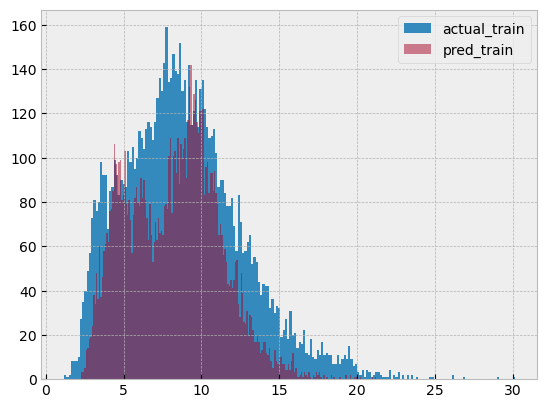

In [42]:
plt.plot(portfolio_actual_train, label="actual_train")
plt.plot(portfolio_pred_train, label="pred_train")
plt.legend()
plt.show()

plt.scatter(portfolio_actual_train, portfolio_pred_train)
plt.show()

plt.hist(portfolio_actual_train, label="actual_train", bins = 200)
plt.hist(portfolio_pred_train, label="pred_train",alpha =0.5, bins = 200)
plt.legend()
plt.show()

In [43]:
nmae(portfolio_pred_train,portfolio_actual_train)

0.20471119018477055

# Porfolio prediction on Test Data Set

In [44]:
df_dict_test.keys()

dict_keys(['854', '123', '852', '222', '484', '404', '992', '319', '583', '801', '987', '299', '640', '744', '241', '200', '441', '192', '621', '313', '464', '424', '993', '598', '514', '745', '927', '945', '352', '980', '644', '683', '244', '677', '351', '118', '595', '255', '554', '318', '743', '947', '480', '219', '780', '909', '977', '272', '521', '842', '267', '396', '290', '601', '901', '260', '618', '629', '238', '231', '875', '889', '340', '906', '604', '525', '460', '130', '363', '250', '666', '438', '986', '462', '188', '763', '923', '925', '822', '131', '456', '624', '827', '474', '912', '194', '706', '522', '999', '113', '247', '657', '890', '412', '261', '957', '600'])

In [45]:
pred_home_test = {}
for home_num in df_dict_test.keys():
    X_test, y_test = df_dict_test[home_num][FEATURES], df_dict_test[home_num][TARGET]
    pred = model.predict(X_test)
    pred_home_test[home_num] = pd.DataFrame({
                                 "actual": np.exp(y_test)-0.01,
                                 "pred": np.exp(pred)-0.01,
                                 "home_num" : home_num})
    

In [46]:
portfolio_actual_test = pd.pivot(combine_data(pred_home_test).reset_index(),
                         columns= "home_num",
                         values="actual",
                         index="time").sum(axis=1)

portfolio_pred_test = pd.pivot(combine_data(pred_home_test).reset_index(),
                         columns= "home_num",
                         values="pred",
                         index="time").sum(axis=1)

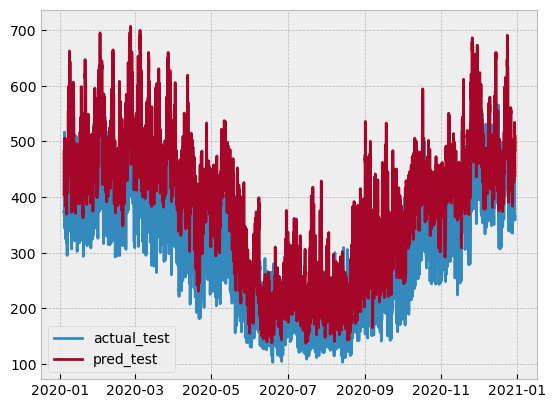

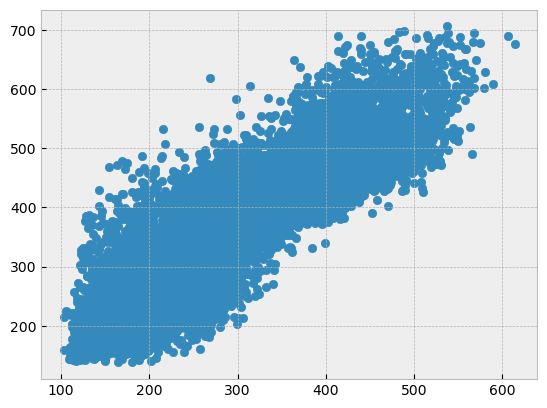

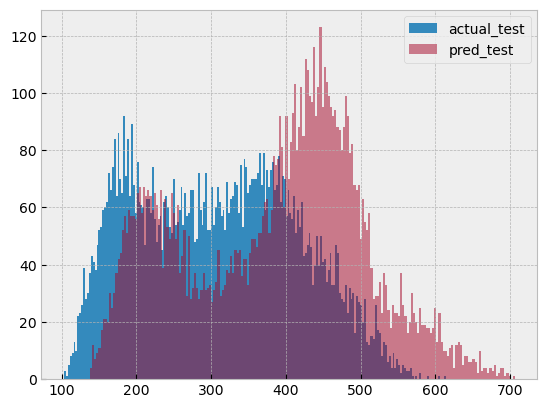

In [47]:
plt.plot(portfolio_actual_test, label="actual_test")
plt.plot(portfolio_pred_test, label="pred_test")
plt.legend()
plt.show()

plt.scatter(portfolio_actual_test, portfolio_pred_test)
plt.show()


plt.hist(portfolio_actual_test, label="actual_test", bins = 200)
plt.hist(portfolio_pred_test, label="pred_test",alpha =0.5, bins = 200)
plt.legend()
plt.show()

In [48]:
nmae(portfolio_pred_test,portfolio_actual_test)

0.25847211303839474